### ay data need to be in the NetCDF before the debiasing the ACS chl
#### Note: this is based on the NASA HPLC xls file for AMT29

In [1]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt

In [3]:
%matplotlib notebook

In [4]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [5]:
DIN_hplc = "/data/datasets/cruise_data/active/AMT23/HPLC/"
DIN_acs = "/users/rsg/tjor/scratch_network/AMT_underway/AMT23/Processed/underway/Step3/"

In [6]:
fn_hplc =  "AMT_23_Pigments.xlsx"
#fn_meta = "Filtering-Log-HPLC-AMT26.csv"
fn_optics = "amt23_final.nc"

In [7]:
print(DIN_hplc + fn_hplc)

df_hplc = pd.read_excel(DIN_hplc + fn_hplc, sheet_name = "BODC_submission_template", header = 16, engine = 'openpyxl', nrows=130)
df_hplc.keys()

#list(df_hplc['Sample name'])
df_hplc.rename(columns={'Sample name': 'Label'}, inplace = True)

print(df_hplc.keys())
print(df_hplc['Label'])
#acs_filtered2 = acs_filtered


# df_hplc

/data/datasets/cruise_data/active/AMT23/HPLC/AMT_23_Pigments.xlsx
Index(['Label', 'Sample Collector', 'Cruise Name', 'CTD number',
       'CTD bottle number', 'Volume filtered (L)', 'station',
       'Name of Water Body', 'collected with positive pressure or vacuum',
       'Sequential Day of Year', 'Depth (meters)', 'Time on deck (GMT)',
       'Latitude', 'Longitude', 'Filter storage before analysis',
       'Filter type', 'Filter diameter (mm)', '[TChl a]', '[TChl b]',
       '[TChl c]', '[Caro]', '[Allo]', '[But fuco]', '[Diad]', '[Diato]',
       '[Fuco]', '[Hex fuco]', '[Perid]', '[Zea]', '[Chl a]', '[DVChl a]',
       '[Chlide a]', '[Chl b] + [DVChl b]', '[Chl c1]', '[Chl c2]', '[Chl c3]',
       '[βε-Car]', '[ββ-Car]', '[Lut]', '[Neo]', '[Viola]', '[Pras]', '[Anth]',
       '[Asta]', 'blank intentionally', '[TChl]', '[PPC]', '[PSC]', '[PSP]',
       '[TAcc]', '[TPig]', '[TAcc]/[Tchla]', '[PPC]/[Tpig]', '[PSP]/[TPig]',
       '[TChl a]/[TPig]'],
      dtype='object')
0       AMT

In [8]:
# NO META DATA IN AMT23 - ALL INFO IS IN BODC TEMPLATE

#print(DIN_hplc + fn_meta)
#df_meta = pd.read_csv(DIN_hplc + fn_meta, header = 0)
#df_meta.keys()
#list(df_meta['NAME'])
# df_meta

#label = []; # match sample/name ID between meta and hplc file
#for i in range(len(df_meta)):
 #   old_string = (str(df_meta['NAME'][i]))
  #  new_string = old_string.replace(":", "" )
   # label.append(new_string)

#df_meta['Label'] = label


#print(df_meta['Label'])

In [9]:
# merge two tables to extract info from df_meta

#print(df_hplc['Label'])
#print(df_meta['Label'])

#df_hplc = pd.merge(df_hplc, df_meta, on=['Label'])

#sorted(df_hplc.keys())

In [10]:
# convert PML pigment names to NASA pigment names for submission
#                            PML  :  NASA


pml2nasa = {            
                          "[Allo]":"Allo",
                          "[Asta]": "Asta",
                          "[Anth]": "PML_only_Anth",
                      "[But fuco]":"But-fuco",
                          "[Caro]":"Alpha-beta-Car", # !!!! TO CHECK !!!
                         "[Chl a]":'Chl_a',
             "[Chl b] + [DVChl b]":"PML_only_Chl_b_DVChl_b",
                        '[Chl c1]':'Chl_c1',
                        '[Chl c2]':'Chl_c2',
                        '[Chl c3]':'Chl_c3',
                      "[Chlide a]":"Chlide_a",
                          "[Diad]":"Diadino",
                         "[Diato]":"Diato",
                       "[DVChl a]":"DV_Chl_a",
                          "[Fuco]":"Fuco",
                      "[Hex fuco]":"Hex-fuco",
                           "[Lut]":"Lut",
                    #     '[MgDVP]':'Mg_DVP', NOT IN AMT 23
                           '[Neo]':'Neo',
                           "[PPC]":"PPC",
                           "[PSC]":"PSC",
                           "[PSP]":"PSP",
                         "[Perid]":"Perid",
                          "[Pras]":"Pras",
                           "[Zea]":"Zea",
                          "[TAcc]":"Tacc",
                          "[TChl]":"TChl",
                        "[TChl a]":"Tot_Chl_a",
                        "[TChl b]":"Tot_Chl_b",
                        "[TChl c]":"Tot_Chl_c",
                          '[TPig]': "Tpg",
                         '[Viola]':'Viola',
                        '[ββ-Car]':"beta-beta-Car",
                        '[βε-Car]':"beta-epi-Car",                  
            
           }
#                     "a-carotene":"Alpha-beta-Car", # these two successive pigments need to be merged (see below)
#                     "b-carotene":"Alpha-beta-Car"}

# rename DHI columns with NASA names
df_hplc = df_hplc.rename(columns = pml2nasa)

# create merged pigments
# "Alpha-beta-Car", 
#df_hplc["Alpha-beta-Car"] = df_hplc["a-carotene"] + df_hplc["b-carotene"] - ALREADY IN MERGED FORMAT
#df_hplc = df_hplc.drop(columns=["a-carotene", "b-carotene"]) - 
           
# "Chl c1c2"
#df_hplc["Chl_c1c2"] = df_hplc["Chl_c2"] + df_hplc["Chl_c1"]  +df_hplc["Mg_DVP"] #  Mg_DVP', NOT IN AMT 23


# "Tot_Chl_a" = DV_Chl_a + MV_Chl_a + Chlide_a (+ Chl_a allomers + Chl_a epimers)   - ALREADY IN MERGED FORMAT
#df_hplc["Tot_Chl_a"] = df_hplc["DV_Chl_a"] + df_hplc["MV_Chl_a"] + df_hplc["Chlide_a"]

# "Tot_Chl_c" = Tot_Chl_a + Tot_Chl_b + Tot_Chl_c - ALREADY IN MERGED FORMAT
#df_hplc["Tot_Chl_c"] = df_hplc["Chl_c3"] + df_hplc["Chl_c1c2"]

# "Tchl" = Tot_Chl_a + Tot_Chl_b + Tot_Chl_c - ALREADY IN MERGED FORMAT
#df_hplc["Tchl"] = df_hplc["Tot_Chl_a"] + df_hplc["Tot_Chl_b"] + df_hplc["Tot_Chl_c"]

# "PPC" (photoprotective carotenoids) = allo + diadino + diato + zea + alpha-beta-car)
#f_hplc["PPC"] = df_hplc["Allo"] + df_hplc["Diadino"] + df_hplc["Diato"] + df_hplc["Zea"] + df_hplc["Alpha-beta-Car"]

# "PSC" (photosynthetic carotenoids) = but-fuco + fuco + hex-fuco + perid
#df_hplc["PSC"] = df_hplc["But-fuco"] + df_hplc["Fuco"] + df_hplc["Hex-fuco"] + df_hplc["Perid"] 

# "PSP" (phosynthetic pigments) = PSC + TChl
#df_hplc["PSP"] = df_hplc["PSC"] + df_hplc["Tchl"] 

# "Tcar" (total carotenoids) = PPC + PSC
df_hplc["Tcar"] = df_hplc["PPC"] + df_hplc["PSC"] 

# "Tacc" (total accessory pigments) = PPC + PSC + Tot_Chl_b + Tot_Chl_c  - ALREADY IN MERGED FORMAT
#df_hplc["Tacc"] = df_hplc["PPC"] + df_hplc["PSC"] + df_hplc["Tot_Chl_b"] + df_hplc["Tot_Chl_c"] 

# "Tpg" (total pigments) = TAcc + Tot_Chl_a - ALREADY IN MERGED FORMAT
#df_hplc["Tpg"] = df_hplc["Tacc"] + df_hplc["Tot_Chl_a"] 

# "DP" (total diagnostic pigments) = PSC + allo + zea + Tot_Chl_b
df_hplc["DP"] = df_hplc["PSC"] + df_hplc["Allo"] + df_hplc["Zea"] + df_hplc["Tot_Chl_b"]


# new dictionary with additional pigments
derived_pigs = {#"Alpha-beta-Car":"Alpha-beta-Car",
                "Chl_c1c2":"Chl_c1c2",
               # "Tot_Chl_a":"Tot_Chl_a", - already added
               # "Tot_Chl_c":"Tot_Chl_c",
                #"Tchl":"Tchl",
                #"PPC":"PPC",
                #"PSC":"PSC",
                #"PSP":"PSP",
                "Tcar":"Tcar",
                "DP":"DP"      }


# drop pigment ratios 

df_hplc.keys()



Index(['Label', 'Sample Collector', 'Cruise Name', 'CTD number',
       'CTD bottle number', 'Volume filtered (L)', 'station',
       'Name of Water Body', 'collected with positive pressure or vacuum',
       'Sequential Day of Year', 'Depth (meters)', 'Time on deck (GMT)',
       'Latitude', 'Longitude', 'Filter storage before analysis',
       'Filter type', 'Filter diameter (mm)', 'Tot_Chl_a', 'Tot_Chl_b',
       'Tot_Chl_c', 'Alpha-beta-Car', 'Allo', 'But-fuco', 'Diadino', 'Diato',
       'Fuco', 'Hex-fuco', 'Perid', 'Zea', 'Chl_a', 'DV_Chl_a', 'Chlide_a',
       'PML_only_Chl_b_DVChl_b', 'Chl_c1', 'Chl_c2', 'Chl_c3', 'beta-epi-Car',
       'beta-beta-Car', 'Lut', 'Neo', 'Viola', 'Pras', 'PML_only_Anth', 'Asta',
       'blank intentionally', 'TChl', 'PPC', 'PSC', 'PSP', 'Tacc', 'Tpg',
       '[TAcc]/[Tchla]', '[PPC]/[Tpig]', '[PSP]/[TPig]', '[TChl a]/[TPig]',
       'Tcar', 'DP'],
      dtype='object')

In [11]:
# drop pigment ratios 
#df_hplc = df_hplc.drop('void1') # redumdant
#df_hplc = df_hplc.drop('[PPC]/[Tpig]') # redumdant
#df_hplc = df_hplc.drop('[PSP]/[TPig]') # redumdant
#df_hplc = df_hplc.drop('[TChl a]/[TPig]') # redumdant

#df_hplc['[TAcc]/[Tchla]'] =[]

In [12]:
# merge dictonaries with names of all pigments
all_pigs = dict(pml2nasa, **derived_pigs)

print(all_pigs)

{'[Allo]': 'Allo', '[Asta]': 'Asta', '[Anth]': 'PML_only_Anth', '[But fuco]': 'But-fuco', '[Caro]': 'Alpha-beta-Car', '[Chl a]': 'Chl_a', '[Chl b] + [DVChl b]': 'PML_only_Chl_b_DVChl_b', '[Chl c1]': 'Chl_c1', '[Chl c2]': 'Chl_c2', '[Chl c3]': 'Chl_c3', '[Chlide a]': 'Chlide_a', '[Diad]': 'Diadino', '[Diato]': 'Diato', '[DVChl a]': 'DV_Chl_a', '[Fuco]': 'Fuco', '[Hex fuco]': 'Hex-fuco', '[Lut]': 'Lut', '[Neo]': 'Neo', '[PPC]': 'PPC', '[PSC]': 'PSC', '[PSP]': 'PSP', '[Perid]': 'Perid', '[Pras]': 'Pras', '[Zea]': 'Zea', '[TAcc]': 'Tacc', '[TChl]': 'TChl', '[TChl a]': 'Tot_Chl_a', '[TChl b]': 'Tot_Chl_b', '[TChl c]': 'Tot_Chl_c', '[TPig]': 'Tpg', '[Viola]': 'Viola', '[ββ-Car]': 'beta-beta-Car', '[βε-Car]': 'beta-epi-Car', 'Chl_c1c2': 'Chl_c1c2', 'Tcar': 'Tcar', 'DP': 'DP'}


In [13]:
# find matching keys and merge them into a single one
for key in df_hplc.keys():
    if "_x" in key:
        print(key)
        if ~(np.all(df_hplc[key] == df_hplc[key[:-1]+"y"])):
            print([key, " not matching"])
        else:
            # drop *_x key
            print(["droppping " + key ])
            df_hplc = df_hplc.drop(columns = [key])
            # rename *_y key
            print(["renaming " + key ])
            df_hplc = df_hplc.rename(columns = {key[:-1]+"y" : key[:-2]})
            

In [14]:
# convert date (numpy.datetime64) and time (datetime.time) to a single datetime object
from datetime import datetime as dt

date = [dt.strptime('13' + str(df_hplc['Sequential Day of Year'][i]), '%y%j').date() for i in range(len(df_hplc))]
time_inday =  [dt.strptime(str(df_hplc['Time on deck (GMT)'][i]), '%H:%M:%S').time() for i in range(len(df_hplc))]

# add Time object to Date object to get DateTime object
time = [dt.combine(date[i],time_inday[i]) for i in range(len(df_hplc))]

# create "Time" key in df_hplc
df_hplc['time'] = time

# drop Date and Time
df_hplc = df_hplc.drop(columns = ["Sequential Day of Year", "Time on deck (GMT)"])
                       
df_hplc = df_hplc.sort_values(by = ['time'])
df_hplc = df_hplc.reset_index(drop = True)

#df_hplc.keys()
#print(date)
print(time)


[datetime.datetime(2013, 10, 9, 12, 0), datetime.datetime(2013, 10, 9, 12, 0), datetime.datetime(2013, 10, 10, 4, 43), datetime.datetime(2013, 10, 10, 4, 43), datetime.datetime(2013, 10, 10, 12, 11), datetime.datetime(2013, 10, 10, 12, 11), datetime.datetime(2013, 10, 11, 4, 43), datetime.datetime(2013, 10, 11, 4, 43), datetime.datetime(2013, 10, 11, 12, 15), datetime.datetime(2013, 10, 11, 12, 15), datetime.datetime(2013, 10, 12, 4, 45), datetime.datetime(2013, 10, 12, 4, 45), datetime.datetime(2013, 10, 12, 12, 15), datetime.datetime(2013, 10, 12, 12, 15), datetime.datetime(2013, 10, 13, 4, 46), datetime.datetime(2013, 10, 12, 4, 46), datetime.datetime(2013, 10, 13, 13, 7), datetime.datetime(2013, 10, 13, 13, 7), datetime.datetime(2013, 10, 14, 4, 48), datetime.datetime(2013, 10, 14, 4, 48), datetime.datetime(2013, 10, 14, 12, 13), datetime.datetime(2013, 10, 14, 12, 13), datetime.datetime(2013, 10, 15, 5, 16), datetime.datetime(2013, 10, 15, 5, 16), datetime.datetime(2013, 10, 15, 1

In [15]:

df_hplc.keys() 

# clean up lat
#tmpla = df_hplc['Lat'].values
#for i,la in enumerate(tmpla):
   # if (type(la) != float) & (type(la) != int):
#         print(type(la))
#         print(i, "    ", la)
        # assume the string is similar to "31°31.784'W"
        
        # replace "º" by "°"
     #   la = la.replace("º", "°")
        
    #    degrees = float(la.split("°")[0]) 
     #   minutes = float(la.split("°")[-1].split("'")[0])
    #    NoS = la.split("°")[-1].split("'")[-1]
     #   sign = -1
      #  if (NoS.upper() == "N"):
          #  sign = 1
       # df_hplc.at[i, 'Lat'] = sign*(degrees + minutes/60.)

# clean up lon
#tmplo = df_hplc['Lon'].values
#for i,lo in enumerate(tmplo):
 #   if (type(lo) != float) & (type(lo) != int):
#         print(type(lo))
#         print(i, "    ", lo)
        # assume the string is similar to "31°31.784'"
        
        # replace "º" by "°"
  #      lo = lo.replace("º", "°")
        
   #     degrees = float(lo.split("°")[0]) 
    #    minutes = float(lo.split("°")[-1].split("'")[0])
     #   EoW = lo.split("°")[-1].split("'")[-1]
      #  sign = -1
      #  if (EoW.upper() == "E"):
       #     sign = 1
       # df_hplc.at[i, 'Lon'] = sign*(degrees + minutes/60.)
        
df_hplc.rename(columns={'Latitude': 'Lat'}, inplace = True)
df_hplc.rename(columns={'Longitude': 'Lon'}, inplace = True)
#print(df_hplc.keys())


In [16]:

        
sorted(df_hplc['Depth (meters)'])

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 10,
 23,
 30,
 30,
 35,
 39,
 40,
 40,
 40,
 45,
 47,
 50,
 50,
 50,
 58,
 60,
 60,
 60,
 60,
 60,
 75,
 75,
 77,
 85,
 85,
 90,
 90,
 94,
 95,
 95,
 95,
 95,
 98,
 100,
 104,
 105,
 109,
 115,
 115,
 120,
 122,
 127,
 132,
 133,
 135,
 135,
 135,
 145,
 145,
 155,
 155,
 160,
 161,
 165,
 170]

In [17]:
# extract surface data

# replace UND label with nominal depth of rUNDerway measurements
#df_hplc.Depth[df_hplc.Depth=="UND"] = 7

#isurf = df_hplc["Depth"]<10
#df_hplc_surf = df_hplc[isurf]
#df_hplc_surf = df_hplc_surf.set_index("time")
#df_hplc_surf

#[df_hplc['Depth (meters)'][i] = 7 for i in range(len(df_hplc))]

df_hplc.loc[df_hplc['Depth (meters)'] == '2', 'Depth (meters)'] = '7'


isurf = df_hplc["Depth (meters)"]<10
df_hplc_surf = df_hplc[isurf]
df_hplc_surf = df_hplc_surf.set_index("time")
df_hplc_surf


,Label,Sample Collector,Cruise Name,CTD number,CTD bottle number,Volume filtered (L),station,Name of Water Body,collected with positive pressure or vacuum,Depth (meters),...,PSC,PSP,Tacc,Tpg,[TAcc]/[Tchla],[PPC]/[Tpig],[PSP]/[TPig],[TChl a]/[TPig],Tcar,DP
time,,,,,,,,,,,,,,,,,,,,,
2013-10-09 12:00:00,AMT23_ctd001_2B,Robert Brewin,AMT23,1,23,2.0,1,Atlantic Ocean,V,2,...,0.133888,0.383443,0.284041,0.449652,1.715108,0.147245,0.852755,0.368310,0.200096,0.184989
2013-10-10 04:43:00,AMT23_ctd003_2B,Robert Brewin,AMT23,3,23,2.0,2,Atlantic Ocean,V,2,...,0.117865,0.423402,0.324064,0.521638,1.640221,0.188322,0.811678,0.378756,0.216101,0.223394
2013-10-10 12:11:00,AMT23_ctd005_2B,Robert Brewin,AMT23,5,21,2.0,3,Atlantic Ocean,V,2,...,0.056923,0.228744,0.186958,0.298557,1.675256,0.233835,0.766165,0.373796,0.126736,0.129094
2013-10-11 04:43:00,AMT23_ctd006_2B,Robert Brewin,AMT23,6,23,2.0,4,Atlantic Ocean,V,2,...,0.035681,0.150263,0.130040,0.205473,1.723915,0.268696,0.731304,0.367119,0.090891,0.091554
2013-10-11 12:15:00,AMT23_ctd007_2B,Robert Brewin,AMT23,7,22,2.0,5,Atlantic Ocean,V,2,...,0.031834,0.127728,0.108458,0.181223,1.490528,0.295189,0.704811,0.401521,0.085329,0.082674
2013-10-12 04:45:00,AMT23_ctd008_2B,Robert Brewin,AMT23,8,24,3.0,6,Atlantic Ocean,V,2,...,0.033049,0.152063,0.130044,0.215876,1.515104,0.295600,0.704400,0.397598,0.096862,0.097968
2013-10-12 12:15:00,AMT23_ctd009_2B,Robert Brewin,AMT23,9,23,3.0,7,Atlantic Ocean,V,2,...,0.027283,0.159645,0.144700,0.230964,1.677410,0.308789,0.691211,0.373495,0.098603,0.100755
2013-10-13 04:46:00,AMT23_ctd010_2B,Robert Brewin,AMT23,10,24,3.0,8,Atlantic Ocean,V,2,...,0.024062,0.126870,0.104784,0.171066,1.580894,0.258356,0.741644,0.387463,0.068258,0.076846
2013-10-13 13:07:00,AMT23_ctd011_2B,Robert Brewin,AMT23,11,23,3.0,9,Atlantic Ocean,V,2,...,0.030241,0.149906,0.147800,0.223526,1.951778,0.329358,0.670642,0.338779,0.103861,0.099847


In [18]:
# remove 1 micron filter data # Just AMT 26?

#index_keep = [];
#for i in range(len(df_hplc_surf)):
 #   if df_hplc_surf["Label"].iloc[i][-6:-1] != 'Micro':
  #      index_keep.append(i) 

#df_hplc_surf = df_hplc_surf.iloc[index_keep]
                        
              
#df_hplc_surf = df_hplc[isurf]
#df_hplc_surf = df_hplc_surf.set_index("time")
#df_hplc_surf

In [19]:
#type(index_drop)
#df_hplc_surf.drop(index_drop,axis=0)
             
print(df_hplc_surf)

                               Label Sample Collector Cruise Name  CTD number  \
time                                                                            
2013-10-09 12:00:00  AMT23_ctd001_2B    Robert Brewin      AMT23            1   
2013-10-10 04:43:00  AMT23_ctd003_2B    Robert Brewin       AMT23           3   
2013-10-10 12:11:00  AMT23_ctd005_2B    Robert Brewin       AMT23           5   
2013-10-11 04:43:00  AMT23_ctd006_2B    Robert Brewin       AMT23           6   
2013-10-11 12:15:00  AMT23_ctd007_2B    Robert Brewin       AMT23           7   
2013-10-12 04:45:00  AMT23_ctd008_2B    Robert Brewin       AMT23           8   
2013-10-12 12:15:00  AMT23_ctd009_2B    Robert Brewin       AMT23           9   
2013-10-13 04:46:00  AMT23_ctd010_2B    Robert Brewin       AMT23          10   
2013-10-13 13:07:00  AMT23_ctd011_2B    Robert Brewin       AMT23          11   
2013-10-14 04:48:00  AMT23_ctd012_2B    Robert Brewin       AMT23          12   
2013-10-14 12:13:00  AMT23_c

In [20]:
# read ACS data
fn_acs = fn_optics
acs = xr.open_dataset(DIN_acs+fn_acs)
acs.close()


# replace uway_long with uway_lon
if "uway_long" in acs.keys():
    acs.uway_lon = acs.uway_long
    acs = acs.drop(labels="uway_long")

acs

list(acs.keys())

['flow',
 'acs_chl',
 'acs_ap',
 'acs_ap_u',
 'acs_bp',
 'acs_bp_u',
 'acs_cp',
 'acs_cp_u',
 'acs_N',
 'acs2_chl',
 'acs2_ap',
 'acs2_ap_u',
 'acs2_bp',
 'acs2_bp_u',
 'acs2_cp',
 'acs2_cp_u',
 'acs2_N',
 'ac9_chl',
 'ac9_ap',
 'ac9_ap_u',
 'ac9_bp',
 'ac9_bp_u',
 'ac9_cp',
 'ac9_cp_u',
 'ac9_N',
 'bb3_bbp',
 'bb3_bbp_err',
 'bb3_bb02',
 'bb3_bb02_err',
 'bb3_bbp_corr',
 'cstar_cp',
 'cstar_cp_err',
 'uway_lat',
 'uway_lon',
 'uway_air_temp1',
 'uway_humidity1',
 'uway_par',
 'uway_tir1',
 'uway_air_temp2',
 'uway_humidity2',
 'uway_par2',
 'uway_tir2',
 'uway_baro1',
 'uway_baro2',
 'uway_thermosalinograph_temp',
 'uway_conductivity',
 'uway_sal',
 'uway_velocity',
 'uway_chl',
 'uway_sample_temp',
 'uway_flowrate',
 'uway_sst']

In [21]:
# fig, ax = plt.subplots(2,1, figsize=[12,6], sharex=True)
# ax[0].plot(acs.time, acs.uway_lon, '.')
# ax[1].plot(acs.time, acs.uway_lat, '.')


In [22]:
# 

### Add HPLC data to NetCDF file

In [23]:
# convert to lower case some keys in hplc dataframe
#if "Lon" in  df_hplc_surf:
 #   df_hplc_surf = df_hplc_surf.rename(columns = {"Lon":"lon"})
#if "Lat" in  df_hplc_surf:
 #   df_hplc_surf = df_hplc_surf.rename(columns = {"Lat":"lat"})
#if "Time" in  df_hplc_surf:
 #   df_hplc_surf = df_hplc_surf.rename(columns = {"Time":"time"}) # already done
if 'Depth (meters)' in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Depth (meters)":"depth"})


In [24]:
df_hplc_surf.keys()

Index(['Label', 'Sample Collector', 'Cruise Name', 'CTD number',
       'CTD bottle number', 'Volume filtered (L)', 'station',
       'Name of Water Body', 'collected with positive pressure or vacuum',
       'depth', 'Lat', 'Lon', 'Filter storage before analysis', 'Filter type',
       'Filter diameter (mm)', 'Tot_Chl_a', 'Tot_Chl_b', 'Tot_Chl_c',
       'Alpha-beta-Car', 'Allo', 'But-fuco', 'Diadino', 'Diato', 'Fuco',
       'Hex-fuco', 'Perid', 'Zea', 'Chl_a', 'DV_Chl_a', 'Chlide_a',
       'PML_only_Chl_b_DVChl_b', 'Chl_c1', 'Chl_c2', 'Chl_c3', 'beta-epi-Car',
       'beta-beta-Car', 'Lut', 'Neo', 'Viola', 'Pras', 'PML_only_Anth', 'Asta',
       'blank intentionally', 'TChl', 'PPC', 'PSC', 'PSP', 'Tacc', 'Tpg',
       '[TAcc]/[Tchla]', '[PPC]/[Tpig]', '[PSP]/[TPig]', '[TChl a]/[TPig]',
       'Tcar', 'DP'],
      dtype='object')

In [25]:
# create hplc_time coordinate
acs = acs.assign_coords(coords={'hplc_time' : (['hplc_time'], df_hplc_surf.index, {'time zone' : 'UTC'}) })
acs.hplc_time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
acs.hplc_time.encoding['calendar'] = "proleptic_gregorian"


In [26]:
# #### read HPLC metadata on pigments (if NASA)
# hplc_pignm = pd.read_excel(DIN_hplc + fn_hplc, sheet_name = "information", header = 4, engine = 'openpyxl',
#                         nrows = 38, usecols = [1, 3, 4, 12, 13, 14], dtype=str)

# # shift info around in original table
# df1 = hplc_pignm.iloc[:, [0,1,2]]
# df2 = hplc_pignm.iloc[:, [3,4,5]] 
# df2 = df2.rename(columns={ df2.keys()[0]: 'abbreviation',
#                      df2.keys()[1]: 'name',
#                      df2.keys()[2]: 'notes'
#                     })
# df1 = df1.rename(columns={ df1.keys()[0]: 'abbreviation',
#                      df1.keys()[1]: 'name',
#                      df1.keys()[2]: 'notes'
#                     })
# # concatenate to subsets of attributes
# df1 = df1.append(df2, ignore_index=True)

# # find indices with empty abbreviations and drop them
# ind = []
# for irow in range(len(df1['abbreviation'].values)):
#     if type(df1['abbreviation'].values[irow])==float:
#         ind.append(irow)
    
# df_hplc_pignm = df1.drop(ind)    


In [27]:
# df_hplc.plot.scatter(x='lat', y='DV_Chl_b', xlim=(-60,60), ylim=(0,0.3), marker='o', grid='on', alpha=0.5)

In [28]:
### add HPLC variables to acs dataset
# drop time-related columns
#if 'year' in df_hplc_surf.keys():
    #df_hplc_surf = df_hplc_surf.drop(columns=['year', 'month', 'day', 'sdy',
                             #  'water_depth', 'name of water body' ])
print(df_hplc_surf.keys())
#print(df_hplc_surf['Unnamed: 5'])

#df_hplc_surf = df_hplc_surf.drop(columns=['Unnamed: 5'])
                     #         'water_depth', 'name of water body' ])
    
        
df_hplc_surf.rename(columns={'CTD bottle number': 'bottle'}, inplace = True)

Index(['Label', 'Sample Collector', 'Cruise Name', 'CTD number',
       'CTD bottle number', 'Volume filtered (L)', 'station',
       'Name of Water Body', 'collected with positive pressure or vacuum',
       'depth', 'Lat', 'Lon', 'Filter storage before analysis', 'Filter type',
       'Filter diameter (mm)', 'Tot_Chl_a', 'Tot_Chl_b', 'Tot_Chl_c',
       'Alpha-beta-Car', 'Allo', 'But-fuco', 'Diadino', 'Diato', 'Fuco',
       'Hex-fuco', 'Perid', 'Zea', 'Chl_a', 'DV_Chl_a', 'Chlide_a',
       'PML_only_Chl_b_DVChl_b', 'Chl_c1', 'Chl_c2', 'Chl_c3', 'beta-epi-Car',
       'beta-beta-Car', 'Lut', 'Neo', 'Viola', 'Pras', 'PML_only_Anth', 'Asta',
       'blank intentionally', 'TChl', 'PPC', 'PSC', 'PSP', 'Tacc', 'Tpg',
       '[TAcc]/[Tchla]', '[PPC]/[Tpig]', '[PSP]/[TPig]', '[TChl a]/[TPig]',
       'Tcar', 'DP'],
      dtype='object')


In [29]:
## for NASA only
# df_hplc_pignm.abbreviation.values

In [30]:
# if NASA

# # find names of hplc vars
# hplc_cols = df_hplc_surf.keys()
# #add attributes to each variable and add it to acs xr dataset
# _var = ()
# _attrs = {}
# for ivar in hplc_cols:
# #     print(ivar)
#     lbl = ivar.replace(" ", "_").replace("__", "_") # repalce spaces with _
#     print(lbl)
    
#     if 'diameter' in ivar:
#         lbl = lbl[:-5]
#         _attrs = {'units': 'mm'}
#         _var = (['hplc_time'], df_hplc[ivar] ) 
    
#     elif lbl in df_hplc_pignm['abbreviation'].values:
#         # find index of df_hplc_pignm ivar
#         ik = list(df_hplc_pignm['abbreviation']).index(lbl)
# #         print("^^^^^^^^^^^this is a pigment")
#         _attrs = {'units' : 'mg/m3',
#                   'full_pigment_name' : df_hplc_pignm['name'].values[ik],
#                   'notes' : df_hplc_pignm['notes'].values[ik]}
#         _var = (['hplc_time'], df_hplc[ivar])
# #             print(_var)
#     else:
# #         print('nothing to do: ' + ivar)
#         _attrs = {}
#         _var = (['hplc_time'], df_hplc[ivar]) 
        
        
#     acs['hplc_'+lbl] = _var
#     acs['hplc_'+lbl].attrs = _attrs
    
#     # reset _var and _attrs
#     _var = ()
#     _attras = {}
    
# #     print(lbl)


# ## HOW TO CHECK THAT ALL PIGMENTS HAVE HAD THEIR ATTRIBUTES?

In [31]:
pigs_names = {value:key for key, value in all_pigs.items()} 
# pigs_names

In [32]:
# find names of hplc vars
hplc_cols = df_hplc_surf.keys()
#add attributes to each variable and add it to acs xr dataset
_var = ()
_attrs = {}
for ivar in hplc_cols:
#     print(ivar)
    lbl = ivar.replace(" ", "_").replace("__", "_") # repalce spaces with _

    
    if 'diameter' in ivar:
        lbl = lbl[:-5]
        _attrs = {'units': 'mm'}
        _var = (['hplc_time'], df_hplc_surf[ivar] ) 
        acs['hplc_'+lbl.lower()] = _var
        acs['hplc_'+lbl.lower()].attrs = _attrs
#         print(["NOT A PIGM: "+lbl.lower()])
        
    elif lbl in pigs_names.keys():
#         print("^^^^^^^^^^^this is a pigment")
        _attrs = {'units' : 'mg/m3'}
        _var = (['hplc_time'], df_hplc_surf[ivar])
#             print(_var)
        acs['hplc_'+lbl] = _var
        acs['hplc_'+lbl].attrs = _attrs
#         print(lbl)
        
    else:
#         print('nothing to do: ' + ivar)
        _attrs = {}
        _var = (['hplc_time'], df_hplc_surf[ivar]) 
        acs['hplc_'+lbl.lower()] = _var
        acs['hplc_'+lbl.lower()].attrs = _attrs
#         print(["NOT A PIGM: "+lbl.lower()])
        
    
    # reset _var and _attrs
    _var = ()
    _attras = {}
    
#     print(lbl)

print(list(acs.keys()))
## HOW TO CHECK THAT ALL PIGMENTS HAVE HAD THEIR ATTRIBUTES?

['flow', 'acs_chl', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_cp', 'acs_cp_u', 'acs_N', 'acs2_chl', 'acs2_ap', 'acs2_ap_u', 'acs2_bp', 'acs2_bp_u', 'acs2_cp', 'acs2_cp_u', 'acs2_N', 'ac9_chl', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_cp', 'ac9_cp_u', 'ac9_N', 'bb3_bbp', 'bb3_bbp_err', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp_corr', 'cstar_cp', 'cstar_cp_err', 'uway_lat', 'uway_lon', 'uway_air_temp1', 'uway_humidity1', 'uway_par', 'uway_tir1', 'uway_air_temp2', 'uway_humidity2', 'uway_par2', 'uway_tir2', 'uway_baro1', 'uway_baro2', 'uway_thermosalinograph_temp', 'uway_conductivity', 'uway_sal', 'uway_velocity', 'uway_chl', 'uway_sample_temp', 'uway_flowrate', 'uway_sst', 'hplc_label', 'hplc_sample_collector', 'hplc_cruise_name', 'hplc_ctd_number', 'hplc_bottle', 'hplc_volume_filtered_(l)', 'hplc_station', 'hplc_name_of_water_body', 'hplc_collected_with_positive_pressure_or_vacuum', 'hplc_depth', 'hplc_lat', 'hplc_lon', 'hplc_filter_storage_before_analysis', 'hplc_filter_type'

In [33]:
# var = 'hplc_filter_storage_before_shipment_to_GFC'
# ty = [type(acs[var].values[i]) for i,tmp in enumerate(acs[var].values)]

# if ~np.all([ty[i]==ty[0] for i,tmp in enumerate(ty)]):
#     print(ty)


In [34]:
"hplc_ctd" in acs.keys()

False

In [35]:
# ensure that hplc_variables with text and numbers in are arrays of strings
if "hplc_comments" in acs.keys():
    new_comments = [str(acs.hplc_comments.values[i]) for i in range(len(acs.hplc_comments.values))]
    acs['hplc_comments'] = (['hplc_time'], new_comments)

if "hplc_comments_x" in acs.keys():
    new_comments = [str(acs.hplc_comments_x.values[i]) for i in range(len(acs.hplc_comments_x.values))]
    acs['hplc_comments_x'] = (['hplc_time'], new_comments)

if "hplc_comments_y" in acs.keys():
    new_comments = [str(acs.hplc_comments_y.values[i]) for i in range(len(acs.hplc_comments_y.values))]
    acs['hplc_comments_y'] = (['hplc_time'], new_comments)

if "hplc_station" in acs.keys():
    new_st = [str(acs.hplc_station.values[i]) for i in range(len(acs.hplc_station.values))]
    acs['hplc_station'] = (['hplc_time'], new_st)

if "hplc_ctd" in acs.keys():
    new_st = [str(acs.hplc_ctd.values[i]) for i in range(len(acs.hplc_ctd.values))]
    acs['hplc_ctd'] = (['hplc_time'], new_st)
    
    
#acs.rename(columns={'LON': 'hplc_bottle'}, inplace = True)

#new_btl = [str(acs.hplc_bottle.values[i]) for i in range(len(acs.hplc_bottle.values))]
#acs['hplc_bottle'] = (['hplc_time'], new_btl)

for ikey in acs.keys():
    if 'hplc' not in ikey:
        continue
    acs[ikey].dtype
    
acs.keys()

KeysView(<xarray.Dataset>
Dimensions:                                          (time: 20160, acs_wv: 176,
                                                      ac9_wv: 9, acs2_wv: 176,
                                                      bb3_wv: 3, hplc_time: 53)
Coordinates:
  * time                                             (time) datetime64[ns] 20...
  * acs_wv                                           (acs_wv) float64 400.0 ....
  * ac9_wv                                           (ac9_wv) float64 nan ......
  * acs2_wv                                          (acs2_wv) float64 400.0 ...
  * bb3_wv                                           (bb3_wv) float64 470.0 ....
  * hplc_time                                        (hplc_time) datetime64[ns] ...
Data variables: (12/107)
    flow                                             (time) float64 ...
    acs_chl                                          (time) float64 ...
    acs_ap                                           (time, acs_

In [36]:
# add extra metadata
acs['hplc_file'] = fn_hplc

In [37]:
# fig, ax = plt.subplots(1)
# ax.scatter(acs['hplc_lat'].values, acs['hplc_Diato'].values, marker='o', alpha=0.5)
# ax.set_xlim([-60, 60])
# ax.set_ylim([0, 0.06])
# ax.grid('on', ls='--')

In [38]:
# fig, ax = plt.subplots(1, figsize=(10, 4))
# # ax.plot(acs.time, acs.acs_chl/acs.acs_ap[:,acs.wv==490], 'k.', lw=0.5, ms=1, alpha=0.5)
# ax.plot(acs.time, acs.ay_slope, 'r.', lw=0.5, ms=1)
# ax.plot(acs.time, acs.cy_slope, 'k.', lw=0.5, ms=1)
# ax.grid('on', ls='--', lw=0.5)

In [39]:
acs['acs_chl'].attrs

{'acs_chl_units': 'mg/m3',
 'acs_chl_equation': 'chla = (acs.ap(:,wv676)-39/65.*acs.ap(:,wv650)-26/65*acs.ap(:,wv714))./0.014;',
 'acs_chl_comment': 'uncalibrated, not-debiased chl estimated from ACS ap'}

<IPython.core.display.Javascript object>


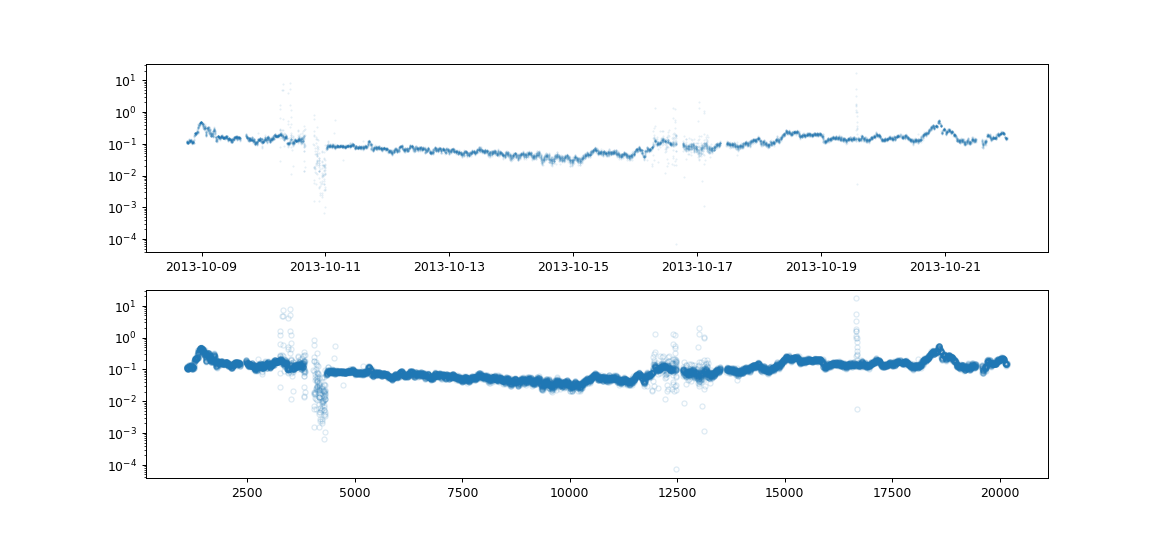

In [40]:
# create acx_chl variable that merges the ac9_chl and acs_chl if available
#acs["acx_chl"] = (['time'], np.nanmean(np.asarray([acs['ac9_chl_adj'].values, acs['acs_chl'].values]), axis=0) )
#acs["acx_chl"].attrs = {"acx_chl_units":"mg/m3",
                      # "acx_chl_comment":"merged the ac9_chl and acs_chl",
                     #  }

# plot it
fig,ax = plt.subplots(2,1, figsize=[13,6])
#ax[0].semilogy(acs.time, acs.acx_chl, 'ro', lw=0.5, ms=5, mfc='none', alpha=0.05)
ax[0].semilogy(acs.time, acs.acs_chl, '.', lw=0.5, ms=1, mfc='none', alpha=0.15)
#ax[0].semilogy(acs.time, acs.ac9_chl_adj, 'k.', lw=0.5, ms=1, mfc='none', alpha=0.15)

#ax[1].semilogy(np.arange(len(acs.time)), acs.acx_chl, 'ro', lw=0.5, ms=5, mfc='none', alpha=0.15)
ax[1].semilogy(np.arange(len(acs.time)), acs.acs_chl, '.', lw=0.5, ms=8, mfc='none', alpha=0.15)

#ax[1].semilogy(np.arange(len(acs.time)), acs.ac9_chl_adj, 'k.', lw=0.5, ms=1, mfc='none', alpha=0.15)

In [41]:
acs

<xarray.Dataset>
Dimensions:                                          (time: 20160, acs_wv: 176,
                                                      ac9_wv: 9, acs2_wv: 176,
                                                      bb3_wv: 3, hplc_time: 53)
Coordinates:
  * time                                             (time) datetime64[ns] 20...
  * acs_wv                                           (acs_wv) float64 400.0 ....
  * ac9_wv                                           (ac9_wv) float64 nan ......
  * acs2_wv                                          (acs2_wv) float64 400.0 ...
  * bb3_wv                                           (bb3_wv) float64 470.0 ....
  * hplc_time                                        (hplc_time) datetime64[ns] ...
Data variables: (12/108)
    flow                                             (time) float64 ...
    acs_chl                                          (time) float64 nan ... 0...
    acs_ap                                           (time, acs_wv) float64 ...
    acs_ap_u                                         (time, acs_wv) float64 ...
    acs_bp                                           (time, acs_wv) float64 ...
    acs_bp_u                                         (time, acs_wv) float64 ...
    ...                                               ...
    hplc_[ppc]/[tpig]                                (hplc_time) float64 0.14...
    hplc_[psp]/[tpig]                                (hplc_time) float64 0.85...
    hplc_[tchl_a]/[tpig]                             (hplc_time) float64 0.36...
    hplc_Tcar                                        (hplc_time) float64 0.20...
    hplc_DP                                          (hplc_time) float64 0.18...
    hplc_file                                        <U20 'AMT_23_Pigments.xlsx'

In [42]:
# manually identify (using plot above) noisy parts of the acs_chl timeseries

i2rm = [ # [1700, 2200], # start and end index of noisy period 1 - examples from AMT26
         #[36970,37200],  # start and end index of noisy period 2
         #[51700,52000]  # start and end index of noisy period 3
       ]

# set values to nan inside the above intervals
for istart,tmp in enumerate(i2rm):
    print(istart, tmp[0], tmp[1])
    acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
    acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan


<IPython.core.display.Javascript object>


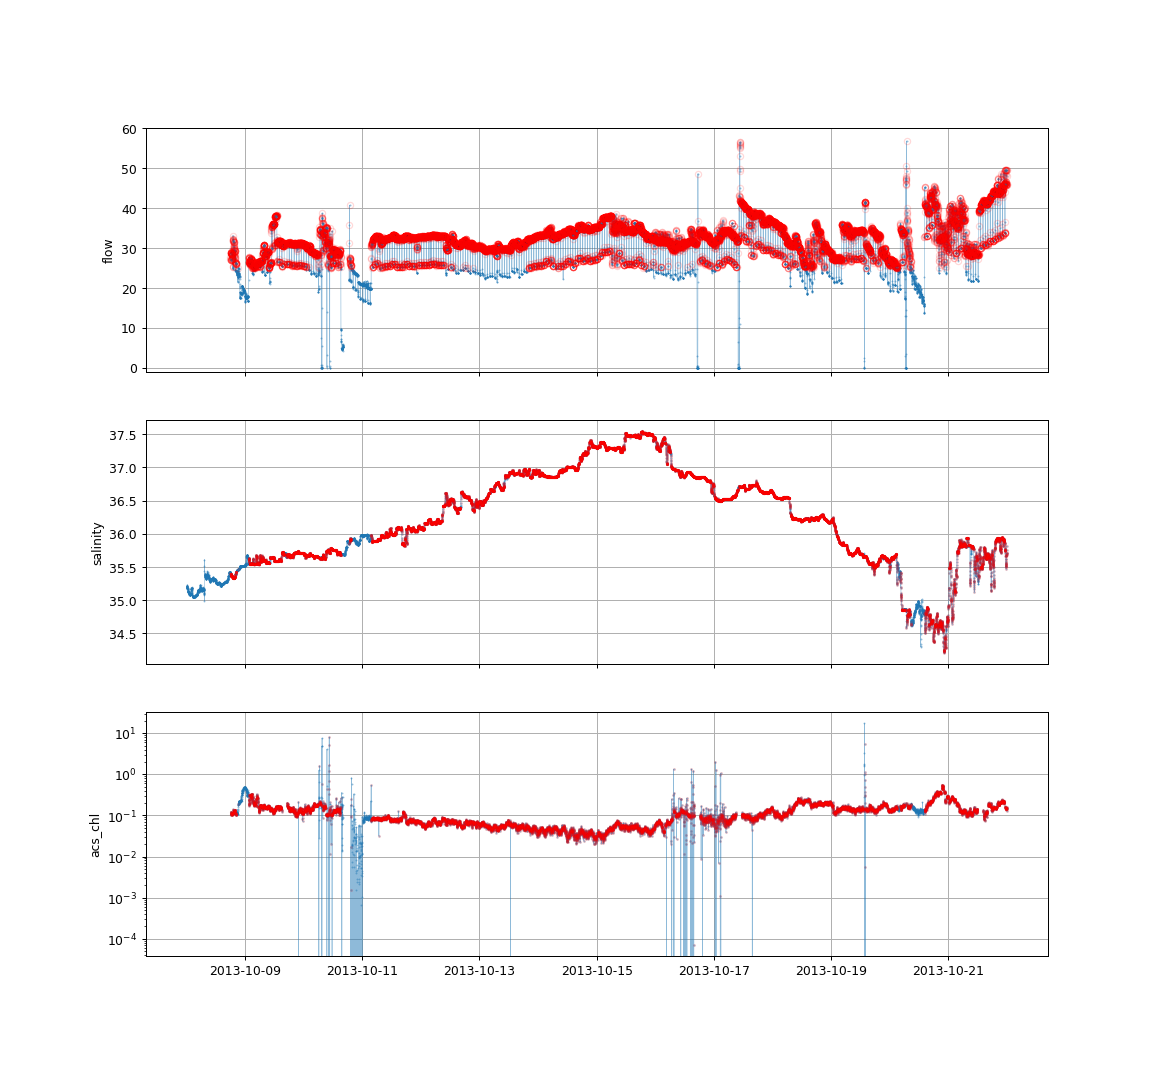

In [43]:
# filter acs data for MQ and noisy events
MIN_FLOW_RATE = 25
MIN_SAL = 33

i2f = np.where(  (acs.flow>MIN_FLOW_RATE) & (acs.uway_sal>MIN_SAL)   )[0]

fig, ax = plt.subplots(3,1, figsize=(13, 12), sharex=True)
ax[0].plot(acs.time, acs.flow, '.-', lw=0.5, ms=1, alpha=0.5)
ax[0].plot(acs.time[i2f], acs.flow[i2f], 'ro', lw=0.5, ms=5, mfc='none', alpha=0.15)
ax[0].set_ylabel('flow')
ax[0].grid('on')
ax[0].set_ylim([-1, 60])

# fig0, ax0 = plt.subplots(1, figsize=(15, 5))
ax[1].plot(acs.time, acs.uway_sal, '.-', lw=0.5, ms=1, alpha=0.5)
ax[1].plot(acs.time[i2f], acs.uway_sal[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[1].set_ylabel('salinity')
ax[1].grid('on')

# fig2, ax2 = plt.subplots(1, figsize=(15, 5))
ax[2].semilogy(acs.time, acs.acs_chl, '.-', lw=0.5, ms=1, alpha=0.5)
ax[2].semilogy(acs.time[i2f], acs.acs_chl[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[2].set_ylabel('acs_chl')
ax[2].grid('on')
# plt.ylim([1e-6, 10])

#print(i2f)
#len(i2f)
#for i in range(len)
 #   print(istart, tmp[0], tmp[1])
  #  acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
   # acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
   #acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan
#for istart,tmp in enumerate(i2f):
 #   print(istart, tmp[0], tmp[1])
  #  acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
   # acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
   # acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan


In [44]:

#df_hplc_surf.keys()
#list(df_hplc['STATION'])
#f_UND = df_hplc_surfloc[(df_hplc_surf['CTD'] == "UND") & (df_hplc_surf['Bottle'] == "UND")]
#df_CTD = f_hplc_surf.loc[(df_hplc_surf['CTD'] != "UND") & (df_hplc_surf['Bottle'] != "UND")]

<IPython.core.display.Javascript object>


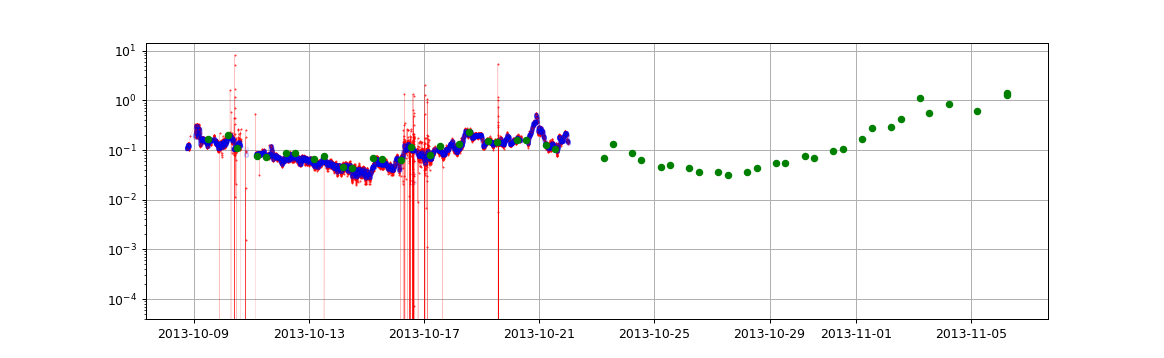

['flow', 'acs_chl', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_cp', 'acs_cp_u', 'acs_N', 'acs2_chl', 'acs2_ap', 'acs2_ap_u', 'acs2_bp', 'acs2_bp_u', 'acs2_cp', 'acs2_cp_u', 'acs2_N', 'ac9_chl', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_cp', 'ac9_cp_u', 'ac9_N', 'bb3_bbp', 'bb3_bbp_err', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp_corr', 'cstar_cp', 'cstar_cp_err', 'uway_lat', 'uway_lon', 'uway_air_temp1', 'uway_humidity1', 'uway_par', 'uway_tir1', 'uway_air_temp2', 'uway_humidity2', 'uway_par2', 'uway_tir2', 'uway_baro1', 'uway_baro2', 'uway_thermosalinograph_temp', 'uway_conductivity', 'uway_sal', 'uway_velocity', 'uway_chl', 'uway_sample_temp', 'uway_flowrate', 'uway_sst', 'hplc_label', 'hplc_sample_collector', 'hplc_cruise_name', 'hplc_ctd_number', 'hplc_bottle', 'hplc_volume_filtered_(l)', 'hplc_station', 'hplc_name_of_water_body', 'hplc_collected_with_positive_pressure_or_vacuum', 'hplc_depth', 'hplc_lat', 'hplc_lon', 'hplc_filter_storage_before_analysis', 'hplc_filter_type'

In [46]:
# median filter data
MEDFILT_WIN = 31

innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges

fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(acs.time[i2f][innan], acs.acs_chl[i2f][innan], 'r.-', lw=0.1, ms=1, mfc='none')
ax2.semilogy(acs.time[i2f][innan], sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=3, mfc='none', alpha = 0.05)
ax2.grid('on')
# plt.ylim([1e-6, 10])

print(list(acs.keys()))
ax2.semilogy(acs.hplc_time, acs.hplc_Tot_Chl_a, 'go', ms=5, alpha=1)#, mfc='none')
#a2.semilogy(df_CTD.index, df_CTD.Tot_Chl_a, 'ko', ms=7, alpha=1, mfc='none', zorder=60)
#ax2.scatter(df_CTD.index, df_CTD.Tot_Chl_a, c=df_CTD.Bottle.values, s=30, alpha=1, zorder=60, cmap = plt.get_cmap('inferno'), vmin=2, vmax=24)
#ax2.semilogy(df_UND.index, df_UND.Tot_Chl_a, 'ks', ms=7, alpha=0.85, mfc='c')

<IPython.core.display.Javascript object>


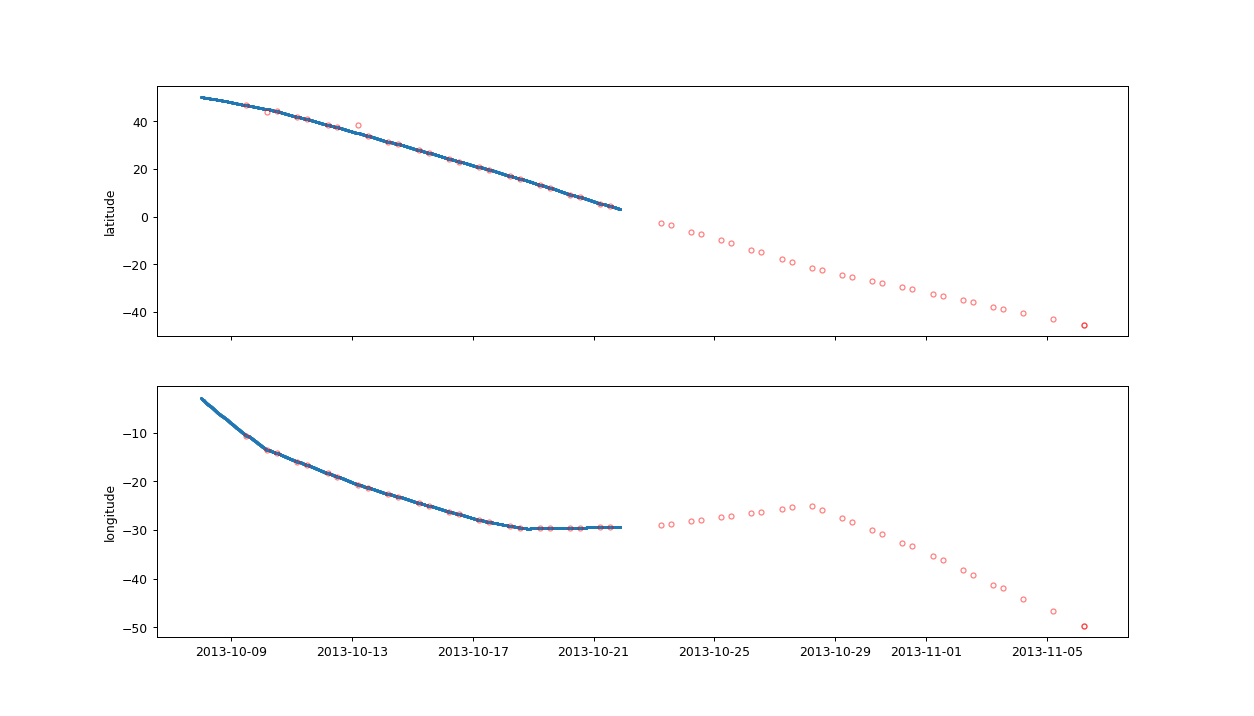

Text(0, 0.5, 'longitude')

In [47]:
# compare lat and lon of hplc and acs datasets
fig, ax = plt.subplots(2, 1, figsize = (14, 8), sharex = True)

ax[0].plot(acs.time, acs.uway_lat, '.', ms = 1, mfc = 'none')
ax[0].plot(acs.hplc_time, acs.hplc_lat, 'ro', ms = 4, mfc = 'none', alpha = 0.5)
ax[0].set_ylabel("latitude")
ax[1].plot(acs.time, acs.uway_lon, '.', ms = 1, mfc = 'none')
ax[1].plot(acs.hplc_time, acs.hplc_lon, 'ro', ms = 4, mfc = 'none', alpha = 0.5)
ax[1].set_ylabel("longitude")

In [48]:
#df_CTD.keys()



In [49]:
# # merge HPCL and ACS data
# # see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate

# # create pandas series with HPLC Tot_Chl_a data
ds_hplc_surf = pd.Series(df_hplc_surf.Tot_Chl_a.values, index = df_hplc_surf.index)

print(df_hplc_surf)

# # averages duplicate values
ds_hplc_surf = ds_hplc_surf.groupby('time').mean() # note - time field sometimes called date?

# # create pandas series with medfilt ACS data
df_acs = pd.Series(sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])



df_hplc_acs = pd.DataFrame({'Tot_Chl_a': ds_hplc_surf, 'acs_chl': df_acs})

df_hplc_acs = df_hplc_acs.interpolate('index').reindex(ds_hplc_surf.index)
# df_hplc_acs

df_hplc_acs = df_hplc_acs.iloc[0:24]

                               Label Sample Collector Cruise Name  CTD number  \
time                                                                            
2013-10-09 12:00:00  AMT23_ctd001_2B    Robert Brewin      AMT23            1   
2013-10-10 04:43:00  AMT23_ctd003_2B    Robert Brewin       AMT23           3   
2013-10-10 12:11:00  AMT23_ctd005_2B    Robert Brewin       AMT23           5   
2013-10-11 04:43:00  AMT23_ctd006_2B    Robert Brewin       AMT23           6   
2013-10-11 12:15:00  AMT23_ctd007_2B    Robert Brewin       AMT23           7   
2013-10-12 04:45:00  AMT23_ctd008_2B    Robert Brewin       AMT23           8   
2013-10-12 12:15:00  AMT23_ctd009_2B    Robert Brewin       AMT23           9   
2013-10-13 04:46:00  AMT23_ctd010_2B    Robert Brewin       AMT23          10   
2013-10-13 13:07:00  AMT23_ctd011_2B    Robert Brewin       AMT23          11   
2013-10-14 04:48:00  AMT23_ctd012_2B    Robert Brewin       AMT23          12   
2013-10-14 12:13:00  AMT23_c

In [50]:
#df_CTD.keys()
df_hplc_acs

,Tot_Chl_a,acs_chl
time,,
2013-10-09 12:00:00,0.165611,0.135137
2013-10-10 04:43:00,0.197574,0.172357
2013-10-10 12:11:00,0.111599,0.131447
2013-10-11 04:43:00,0.075433,0.083368
2013-10-11 12:15:00,0.072765,0.077402
2013-10-12 04:45:00,0.085832,0.078814
2013-10-12 12:15:00,0.086264,0.070670
2013-10-13 04:46:00,0.066282,0.047251
2013-10-13 13:07:00,0.075726,0.057001


In [51]:
df_hplc_surf_new = df_hplc_surf
# merge HPCL and ACS data
# see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
# here made with dataframe instead of series

# averages duplicate values
df_hplc_surf_new = df_hplc_surf_new.groupby('time').mean() 

# create pandas series with medfilt ACS data
df_acs = pd.Series(sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])

df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc_surf_new.Tot_Chl_a, 'acs_chl': df_acs})

df_hplc_acs = df_hplc_acs.interpolate('index').reindex(df_hplc_surf_new.index)
    
df_hplc_acs = df_hplc_acs.iloc[0:24]

/tmp/ipykernel_30288/3619126214.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_hplc_surf_new = df_hplc_surf_new.groupby('time').mean()


In [52]:
# compute residuals and stats
rres = df_hplc_acs.acs_chl.values / df_hplc_acs.Tot_Chl_a.values - 1

rres_log = np.log10(df_hplc_acs.acs_chl.values) / np.log10(df_hplc_acs.Tot_Chl_a.values) - 1

delta = np.nanmedian(rres)
delta_log = np.nanmedian(rres_log)
sigma = prcrng(rres)
sigma_log = prcrng(rres_log)
N = len(rres)

print(delta, sigma, N)

print(delta_log, sigma_log, N)



-0.07949403002868394 0.13889793915787846 24
0.039113106491088456 0.0679579519135956 24


<IPython.core.display.Javascript object>


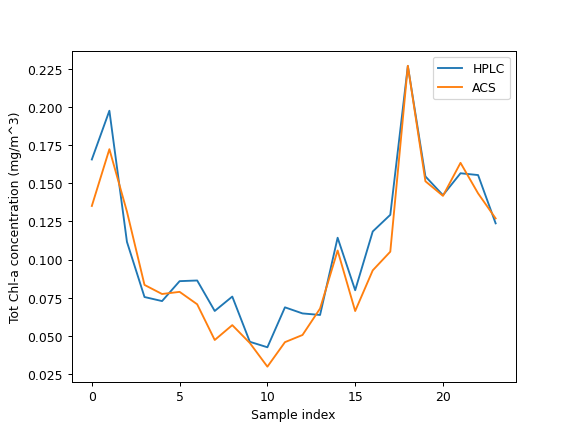

[0.16561096 0.19757361 0.11159938 0.0754328  0.07276489 0.08583201
 0.08626404 0.06628168 0.07572574 0.04607075 0.04248034 0.0686699
 0.06467146 0.06366649 0.11429795 0.07987059 0.11839986 0.12933166
 0.22688366 0.15452072 0.14221166 0.15657956 0.15539549 0.12373056]
[0.13513662 0.17235675 0.13144654 0.08336772 0.07740202 0.07881433
 0.07066972 0.04725149 0.05700074 0.04527839 0.0297569  0.04583029
 0.05053726 0.06787358 0.10592939 0.06623743 0.09290773 0.10515857
 0.22705381 0.15133277 0.14175618 0.16340892 0.1433947  0.1269663 ]


In [53]:
plt.figure()
plt.plot(df_hplc_acs.Tot_Chl_a.values,label='HPLC')
plt.plot(df_hplc_acs.acs_chl.values,label='ACS')
plt.ylabel('Tot Chl-a concentration (mg/m^3)')
plt.xlabel('Sample index')
plt.legend()

print(df_hplc_acs.Tot_Chl_a.values)
print(df_hplc_acs.acs_chl.values)


<IPython.core.display.Javascript object>


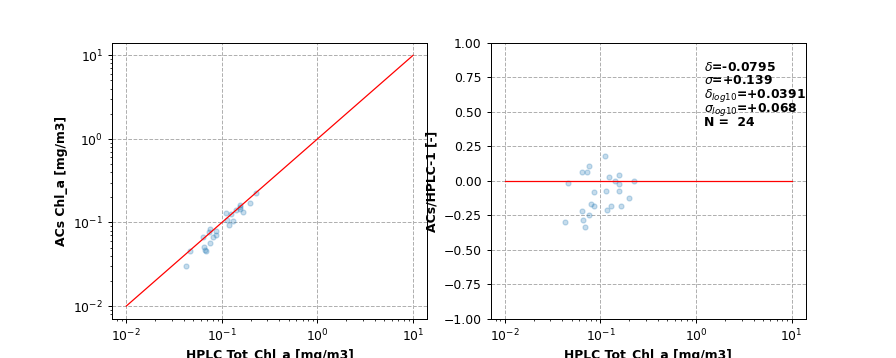

[0.16561096 0.19757361 0.11159938 0.0754328  0.07276489 0.08583201
 0.08626404 0.06628168 0.07572574 0.04607075 0.04248034 0.0686699
 0.06467146 0.06366649 0.11429795 0.07987059 0.11839986 0.12933166
 0.22688366 0.15452072 0.14221166 0.15657956 0.15539549 0.12373056]


In [56]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('ACs/HPLC-1 [-]', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(1.2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.7, r'$\sigma$='+f'{sigma:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.6, r'$\delta_{log10}$='+f'{delta_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.5, r'$\sigma_{log10}$='+f'{sigma_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.4, f'N = {N: 0}', fontweight='bold')




print(df_hplc_acs.Tot_Chl_a.values)

<IPython.core.display.Javascript object>


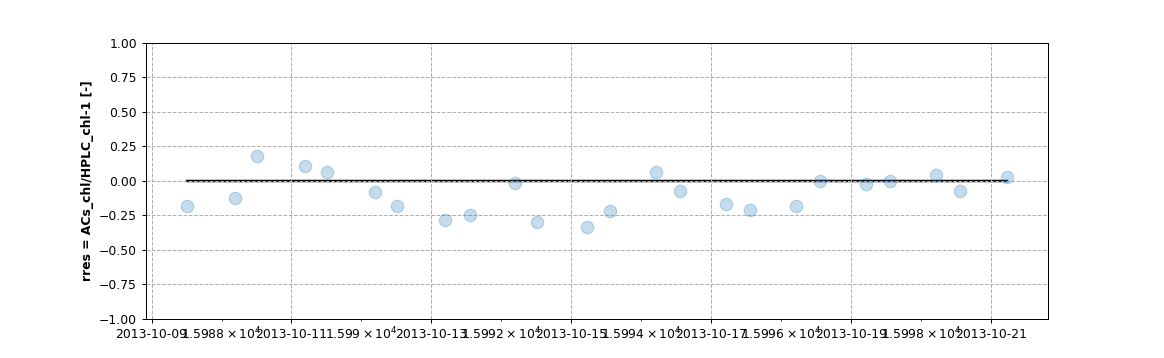

(-1.0, 1.0)

In [55]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.semilogx(df_hplc_acs.index.values, rres, 'o', ms=10, alpha=0.25, zorder=60)
ax.plot(df_hplc_acs.index.values, rres*0, 'k-', lw=2, zorder=1)
ax.set_ylabel('rres = ACs_chl/HPLC_chl-1 [-]', fontweight='bold')
ax.grid('on', ls='--')
ax.set_ylim([-1, 1])

In [56]:
ilrg_rres = np.where(abs(rres)>0.5)[0]
print(rres[ilrg_rres])
df_hplc_surf_new.iloc[ilrg_rres]

[]


,CTD number,bottle,Volume filtered (L),station,Lat,Lon,Filter diameter (mm),Tot_Chl_a,Tot_Chl_b,Tot_Chl_c,...,PSC,PSP,Tacc,Tpg,[TAcc]/[Tchla],[PPC]/[Tpig],[PSP]/[TPig],[TChl a]/[TPig],Tcar,DP
time,,,,,,,,,,,,,,,,,,,,,


In [57]:
df_hplc_surf_new.iloc[ilrg_rres].index.dayofyear
# tt.tm_yday

Int64Index([], dtype='int64', name='time')

In [58]:
df_hplc_surf_new.iloc[ilrg_rres].keys()

Index(['CTD number', 'bottle', 'Volume filtered (L)', 'station', 'Lat', 'Lon',
       'Filter diameter (mm)', 'Tot_Chl_a', 'Tot_Chl_b', 'Tot_Chl_c',
       'Alpha-beta-Car', 'Allo', 'But-fuco', 'Diadino', 'Diato', 'Fuco',
       'Hex-fuco', 'Perid', 'Zea', 'Chl_a', 'DV_Chl_a', 'Chlide_a',
       'PML_only_Chl_b_DVChl_b', 'Chl_c1', 'Chl_c2', 'Chl_c3', 'beta-epi-Car',
       'beta-beta-Car', 'Lut', 'Neo', 'Viola', 'Pras', 'PML_only_Anth', 'Asta',
       'blank intentionally', 'TChl', 'PPC', 'PSC', 'PSP', 'Tacc', 'Tpg',
       '[TAcc]/[Tchla]', '[PPC]/[Tpig]', '[PSP]/[TPig]', '[TChl a]/[TPig]',
       'Tcar', 'DP'],
      dtype='object')

In [59]:
# find dates of large rres
r = df_hplc_acs.acs_chl / df_hplc_acs.Tot_Chl_a - 1
ii = np.where(abs(r)>0.4)[0]
print(r[ii])
# iss = 2
# [df_hplc_acs.Tot_Chl_a[ii][iss], df_hplc_acs.acx_chl[ii][iss]]

Series([], dtype: float64)


In [60]:
# # de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
# df_hplc_acs.acs_chl_debiased = df_hplc_acs.acs_chl*(1-delta)

In [61]:
# # compute resuduals and stats
# rres = df_hplc_acs.acs_chl_debiased.values/df_hplc_acs.Tot_Chl_a.values-1

# delta = np.nanmedian(rres)
# sigma = prcrng(rres)
# N = len(rres)

# print(delta, sigma, N)

In [62]:
# fit data to power law -- not useD?
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x**b

popt, pcov = curve_fit(func, 0.014*df_hplc_acs.acs_chl.values, df_hplc_acs.Tot_Chl_a.values)

perr = np.sqrt(np.diag(pcov)) # parameter uncertainty 

print("chl_HPLC = a * chl_ACS^b " )

print("a = " + f'{popt[0]:.1f} ' + "+/- " + f'{perr[0]:.1f}' )
print("b = " + f'{popt[1]:.3f} ' + "+/- " + f'{perr[1]:.3f}' )


chl_HPLC = a * chl_ACS^b 
a = 34.9 +/- 12.3
b = 0.877 +/- 0.056


In [63]:
# fig, ax = plt.subplots(1,2, figsize=(10, 4))

# ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl_debiased.values, 'o', ms=4, alpha=0.25)
# x = np.logspace(np.log10(0.01), np.log10(10), 100)
# ax[0].loglog(x, x, 'r-', lw=1)
# ax[0].grid('on', ls='--')
# ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
# ax[0].set_ylabel('ACS Chl_a [mg/m3]', fontweight='bold')

# ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
# ax[1].semilogx(x, x*0, 'r-', lw=1)
# ax[1].grid('on', ls='--')
# ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
# ax[1].set_ylabel('ACS/HPLC-1 [-]', fontweight='bold')

# ax[1].text(2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
# ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma: 0.3}', fontweight='bold')
# ax[1].text(2, 0.6, f'N = {N: 0}', fontweight='bold')


In [64]:
# de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0]
acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
# acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
                               'lon [degE]': acs.uway_lon[i2f][innan],
                               'acs_chl_debiased [mg_m3]': acs.acs_chl_debiased[i2f][innan]
                              }  ,
                      index = acs.time.values[i2f][innan])
acs_out.index.rename('date_time [UTC]', inplace = True)

In [65]:
# add attributes to acs_chl_debiased
acs.acs_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_deiased = acs.acs_chl*(1-delta)"
acs.acs_chl_debiased.attrs["delta"] = delta
acs.acs_chl_debiased.attrs["sigma"] = sigma
acs.acs_chl_debiased.attrs["units"] = "mg/m3"
acs.acs_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a.values
acs.acs_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["acs_chl"] = df_hplc_acs.acs_chl.values
acs.acs_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs_chl_debiased.attrs["match_up_dates"] = df_hplc_acs.index.format()


<IPython.core.display.Javascript object>


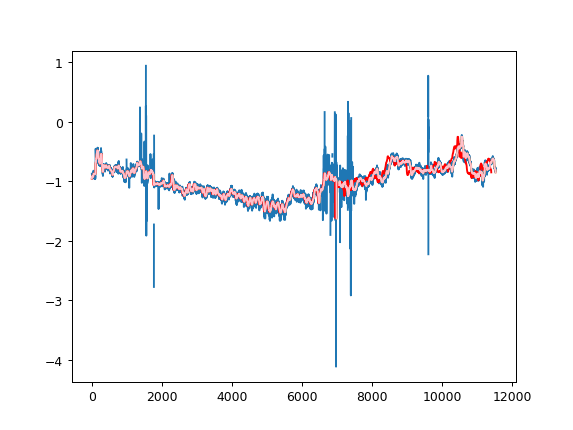

/tmp/ipykernel_29399/757522388.py:3: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(acs['acs_chl_debiased'].values[i2f][innan]))
/tmp/ipykernel_29399/757522388.py:10: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(acs_filtered_x['acs_chl_debiased'].values))
/tmp/ipykernel_29399/757522388.py:25: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(acs_filtered_x['acs_chl_debiased'].values), color='pink')


In [66]:

#step x - # filters w.r.t. i2fn (mQ interval + previous manual spike removal) and innan
plt.figure()
plt.plot(np.log10(acs['acs_chl_debiased'].values[i2f][innan]))
ix = xr.DataArray(acs.time[i2f][innan], dims=['time']) 
acs_filtered_x = acs.sel(time = ix)
acs_filtered_x['acs_chl'].values = sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31) # apply med filter to acx chl and acx chl debiasesd 
acs_filtered_x['acs_chl_debiased'].values = sg.medfilt(acs.acs_chl_debiased[i2f][innan], kernel_size=31)


plt.plot(np.log10(acs_filtered_x['acs_chl_debiased'].values))



#step y - # filters w.r.t. ap (10the element) being > 0
i2kp = np.where((acs_filtered_x.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs_filtered_x.time[i2kp], dims=['time']) 
acs_filtered_xy = acs_filtered_x.sel(time = iy)

#step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_filtered_xy.acs_chl[:] > 0)) [0]
iz = xr.DataArray(acs_filtered_xy.time[i2kp], dims=['time']) 
acs_filtered_xyz = acs_filtered_xy.sel(time = iz)

plt.plot(np.log10(acs_filtered_xyz['acs_chl_debiased'].values),color='red')
plt.plot(np.log10(acs_filtered_x['acs_chl_debiased'].values), color='pink')

In [67]:
#acs_filtered2 = acs_filtered
#acs_filtered2 = acs_filtered2.rename_vars({'time_': 'time'}, )

<IPython.core.display.Javascript object>


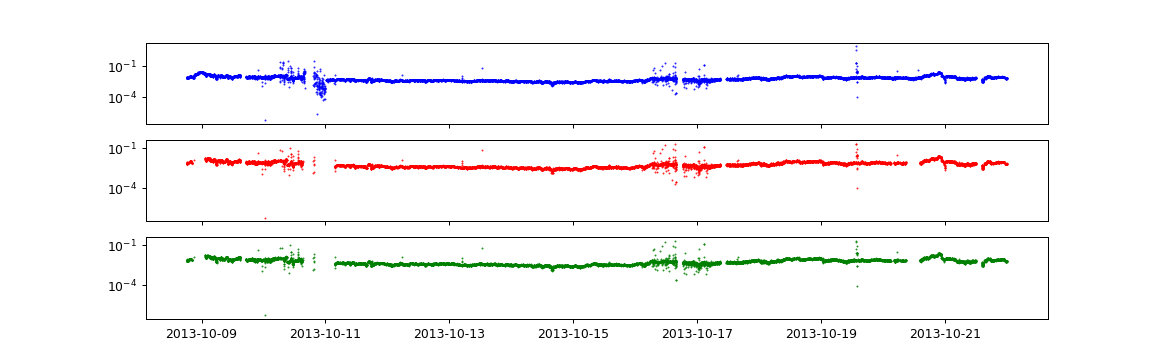

In [68]:
# plot to check                   
#iwv = np.where(acs_filtered.acs_wv==490)[0]
#fig, [ax, ax2] = plt.subplots(2,1, figsize=(13, 4), sharex=True)

#ax.semilogy(acs_filtered.time_[:], acs_filtered.acs_ap[:,iwv], 'b.', ms=1)
# ax.semilogy(acs_filtered.time_[:], sg.medfilt(x, 151), 'b.', ms=1)
#ax.semilogy(acs_filtered2.time, acs_filtered2.acs_ap[:,iwv], 'ro', ms=1, mfc='none', alpha=0.5)
#ax.grid('on')

#ax2.grid('on')

fig, [ax, ax2, ax3] = plt.subplots(3,1, figsize=(13, 4), sharex=True)

iwv = np.where(acs_filtered_x.acs_wv==490)[0]
ax.semilogy(acs.time[:], acs.acs_ap[:,iwv], 'b.', ms=1)

iwv_x = np.where(acs_filtered_x.acs_wv==490)[0]
ax2.semilogy(acs_filtered_x.time[:], acs_filtered_x.acs_ap[:,iwv_x], 'r.', ms=1)

iwv_y = np.where(acs_filtered_xy.acs_wv==490)[0]
ax3.semilogy(acs_filtered_xy.time[:], acs_filtered_xy.acs_ap[:,iwv_y], 'g.', ms=1)
#ax.semilogy(acs_filtered.time[:], sg.medfilt(x, 151), 'b.', ms=1)
#ax.semilogy(acs_filtered2.time, acs_filtered2.acs_ap[:,iwv], 'ro', ms=1, mfc='none', alpha=0.5)
#ax.grid('on')


In [69]:
# save to file for Silvia
# acs_out.to_csv('AMT29_ACS_chl_debiased.csv')
acs_filtered2 =acs_filtered_xyz 

In [70]:
#test for similar keys between AMT28 and AMT29 (baseline)

#load AMT29 (baseline for netcdf)
path_nc_29 = '/data/lazarev1/backup/cruise_data/AMT29/Public_Read_Only_Copy/DY110_Public/Optics_group/Processed/Underway/Step3/amt29_final_with_debiased_chl.nc'
nc_data_29 = xr.open_dataset(path_nc_29)  


#test for common and unqiue keys
keys_23 = list(acs_filtered2.keys())
keys_29 = list(nc_data_29.keys())
common_keys = set(keys_23).intersection(set(keys_23)) # keys contained in both cruises
extra_keys_23 =  set(keys_23) ^ common_keys # extra keys in AMT 28
extra_keys_29 = set(keys_29) ^ common_keys # extra keys in AMT29

print('common keys')
print(sorted(common_keys))

print('/n extra keys in amt233')
print(sorted(extra_keys_23))

# manual clean up of AMT 27 keys
# acs_filtered_xy = acs_filtered_xy.rename_vars({"uway_lon": "uway_long"})
# acs_filtered_xy = acs_filtered_xy.drop("ac9_N")
# acs_filtered_xy = acs_filtered_xy.drop("ac9_chl")

# manual clean up of AMT 26 keys
acs_filtered2 = acs_filtered2.drop('ac9_N')
acs_filtered2 = acs_filtered2.drop('ac9_ap')
acs_filtered2 = acs_filtered2.drop('ac9_ap_u')
acs_filtered2 = acs_filtered2.drop('ac9_bp')
acs_filtered2 = acs_filtered2.drop('ac9_bp_u')
acs_filtered2 = acs_filtered2.drop('ac9_chl')
acs_filtered2 = acs_filtered2.drop('ac9_cp')
acs_filtered2 = acs_filtered2.drop('ac9_cp_u')
#acs_filtered2 = acs_filtered2.drop('hplc_1_micron_(m)_or_not_(n)') # redumdant

acs_filtered2 = acs_filtered2.drop('acs2_N')
acs_filtered2 = acs_filtered2.drop('acs2_ap')
acs_filtered2 = acs_filtered2.drop('acs2_ap_u')
acs_filtered2 = acs_filtered2.drop('acs2_bp')
acs_filtered2 = acs_filtered2.drop('acs2_bp_u')
acs_filtered2 = acs_filtered2.drop('acs2_chl')
acs_filtered2 = acs_filtered2.drop('acs2_cp')
acs_filtered2 = acs_filtered2.drop('acs2_cp_u')
#acs_filtered2 = acs_filtered2.drop('hplc_1_micron_(m)_or_not_(n)') # redumdant

# clean-up extra pigments
acs_filtered2 = acs_filtered2.drop('hplc_[ppc]/[tpig]') # redundant#acs_filtered2 = acs_filtered2.drop('hplc_[psp]/[tpig]') # redundant
acs_filtered2 = acs_filtered2.drop('hplc_[tacc]/[tchla]') # redundant
acs_filtered2 = acs_filtered2.drop('hplc_[tchl_a]/[tpig]') # redundant
acs_filtered2 = acs_filtered2.drop('hplc_[psp]/[tpig]') # redundant
#acs_filtered2 = acs_filtered2.drop('hplc__[chl_c2mgdg-1]') # redundant
#acs_filtered2 = acs_filtered2.drop('hplc__[chl_c2mgdg-2]') # redundant

#acs_filtered_xy = acs_filtered_xy.rename_vars({"uway_lon": "uway_long"})

#print('/n extra keys in amt29')
#print(sorted(extra_keys_29))

#print('/n extra keys in amt26')
#print(sorted(extra_keys_23))
#sorted(acs_filtered2.keys())

common keys
['ac9_N', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_chl', 'ac9_cp', 'ac9_cp_u', 'acs2_N', 'acs2_ap', 'acs2_ap_u', 'acs2_bp', 'acs2_bp_u', 'acs2_chl', 'acs2_cp', 'acs2_cp_u', 'acs_N', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_chl', 'acs_chl_debiased', 'acs_cp', 'acs_cp_u', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp', 'bb3_bbp_corr', 'bb3_bbp_err', 'cstar_cp', 'cstar_cp_err', 'flow', 'hplc_Allo', 'hplc_Alpha-beta-Car', 'hplc_Asta', 'hplc_But-fuco', 'hplc_Chl_a', 'hplc_Chl_c1', 'hplc_Chl_c2', 'hplc_Chl_c3', 'hplc_Chlide_a', 'hplc_DP', 'hplc_DV_Chl_a', 'hplc_Diadino', 'hplc_Diato', 'hplc_Fuco', 'hplc_Hex-fuco', 'hplc_Lut', 'hplc_Neo', 'hplc_PML_only_Anth', 'hplc_PML_only_Chl_b_DVChl_b', 'hplc_PPC', 'hplc_PSC', 'hplc_PSP', 'hplc_Perid', 'hplc_Pras', 'hplc_TChl', 'hplc_Tacc', 'hplc_Tcar', 'hplc_Tot_Chl_a', 'hplc_Tot_Chl_b', 'hplc_Tot_Chl_c', 'hplc_Tpg', 'hplc_Viola', 'hplc_Zea', 'hplc_[ppc]/[tpig]', 'hplc_[psp]/[tpig]', 'hplc_[tacc]/[tchla]', 'hplc_[tchl_a]/[tpig]', 'hplc

In [71]:

#test for common and unqiue keys
keys_26 = list(acs_filtered2.keys())
keys_29 = list(nc_data_29.keys())
common_keys = set(keys_26).intersection(set(keys_29)) # keys contained in both cruises
extra_keys_26 =  set(keys_26) ^ common_keys # extra keys in AMT 28
extra_keys_29 = set(keys_29) ^ common_keys # extra keys in AMT29

print('/n extra keys in amt29')
print(sorted(extra_keys_29))

print('/n extra keys in amt26')
print(sorted(extra_keys_26))
sorted(acs_filtered2.keys())


/n extra keys in amt29
['ay440', 'ay_slope', 'ctd_sal', 'ctd_sst', 'cy440', 'cy_slope', 'hplc_Chl_c1c2', 'hplc_DV_Chl_b', 'hplc_Gyro', 'hplc_MV_Chl_a', 'hplc_MV_Chl_b', 'hplc_PI', 'hplc_PPC_Tcar', 'hplc_PPC_Tpg', 'hplc_PSC_Tcar', 'hplc_PSP_Tpg', 'hplc_Phide_a', 'hplc_Phytin_a', 'hplc_Tacc_Tchla', 'hplc_Tchl', 'hplc_Tchl_Tcar', 'hplc_Tchl_a_Tpg', 'hplc_comments', 'hplc_cruise', 'hplc_filter_storage_before_shipment_to_GFC', 'hplc_hplc_gsfc_id', 'hplc_indicate_if_filters_are_replicates', 'hplc_sample', 'hplc_volfilt', 'uway_air_temp', 'uway_baro', 'uway_depthm', 'uway_fluo', 'uway_gndcourse', 'uway_gndspeed', 'uway_heading', 'uway_heave', 'uway_humidity', 'uway_long', 'uway_par1', 'uway_pitch', 'uway_roll', 'uway_trans', 'uway_wind_dir', 'uway_wind_vel']
/n extra keys in amt26
['hplc_Asta', 'hplc_Chl_a', 'hplc_Chl_c1', 'hplc_Chl_c2', 'hplc_PML_only_Anth', 'hplc_PML_only_Chl_b_DVChl_b', 'hplc_TChl', 'hplc_beta-beta-Car', 'hplc_beta-epi-Car', 'hplc_blank_intentionally', 'hplc_collected_with

['acs_N',
 'acs_ap',
 'acs_ap_u',
 'acs_bp',
 'acs_bp_u',
 'acs_chl',
 'acs_chl_debiased',
 'acs_cp',
 'acs_cp_u',
 'bb3_bb02',
 'bb3_bb02_err',
 'bb3_bbp',
 'bb3_bbp_corr',
 'bb3_bbp_err',
 'cstar_cp',
 'cstar_cp_err',
 'flow',
 'hplc_Allo',
 'hplc_Alpha-beta-Car',
 'hplc_Asta',
 'hplc_But-fuco',
 'hplc_Chl_a',
 'hplc_Chl_c1',
 'hplc_Chl_c2',
 'hplc_Chl_c3',
 'hplc_Chlide_a',
 'hplc_DP',
 'hplc_DV_Chl_a',
 'hplc_Diadino',
 'hplc_Diato',
 'hplc_Fuco',
 'hplc_Hex-fuco',
 'hplc_Lut',
 'hplc_Neo',
 'hplc_PML_only_Anth',
 'hplc_PML_only_Chl_b_DVChl_b',
 'hplc_PPC',
 'hplc_PSC',
 'hplc_PSP',
 'hplc_Perid',
 'hplc_Pras',
 'hplc_TChl',
 'hplc_Tacc',
 'hplc_Tcar',
 'hplc_Tot_Chl_a',
 'hplc_Tot_Chl_b',
 'hplc_Tot_Chl_c',
 'hplc_Tpg',
 'hplc_Viola',
 'hplc_Zea',
 'hplc_beta-beta-Car',
 'hplc_beta-epi-Car',
 'hplc_blank_intentionally',
 'hplc_bottle',
 'hplc_collected_with_positive_pressure_or_vacuum',
 'hplc_cruise_name',
 'hplc_ctd_number',
 'hplc_depth',
 'hplc_file',
 'hplc_filter_diameter',


In [72]:
# save updated NetCDF file

acs_filtered2.to_netcdf(DIN_acs+fn_acs[:-3]+'_with_debiased_chl.nc')
acs_filtered2.close()

<IPython.core.display.Javascript object>


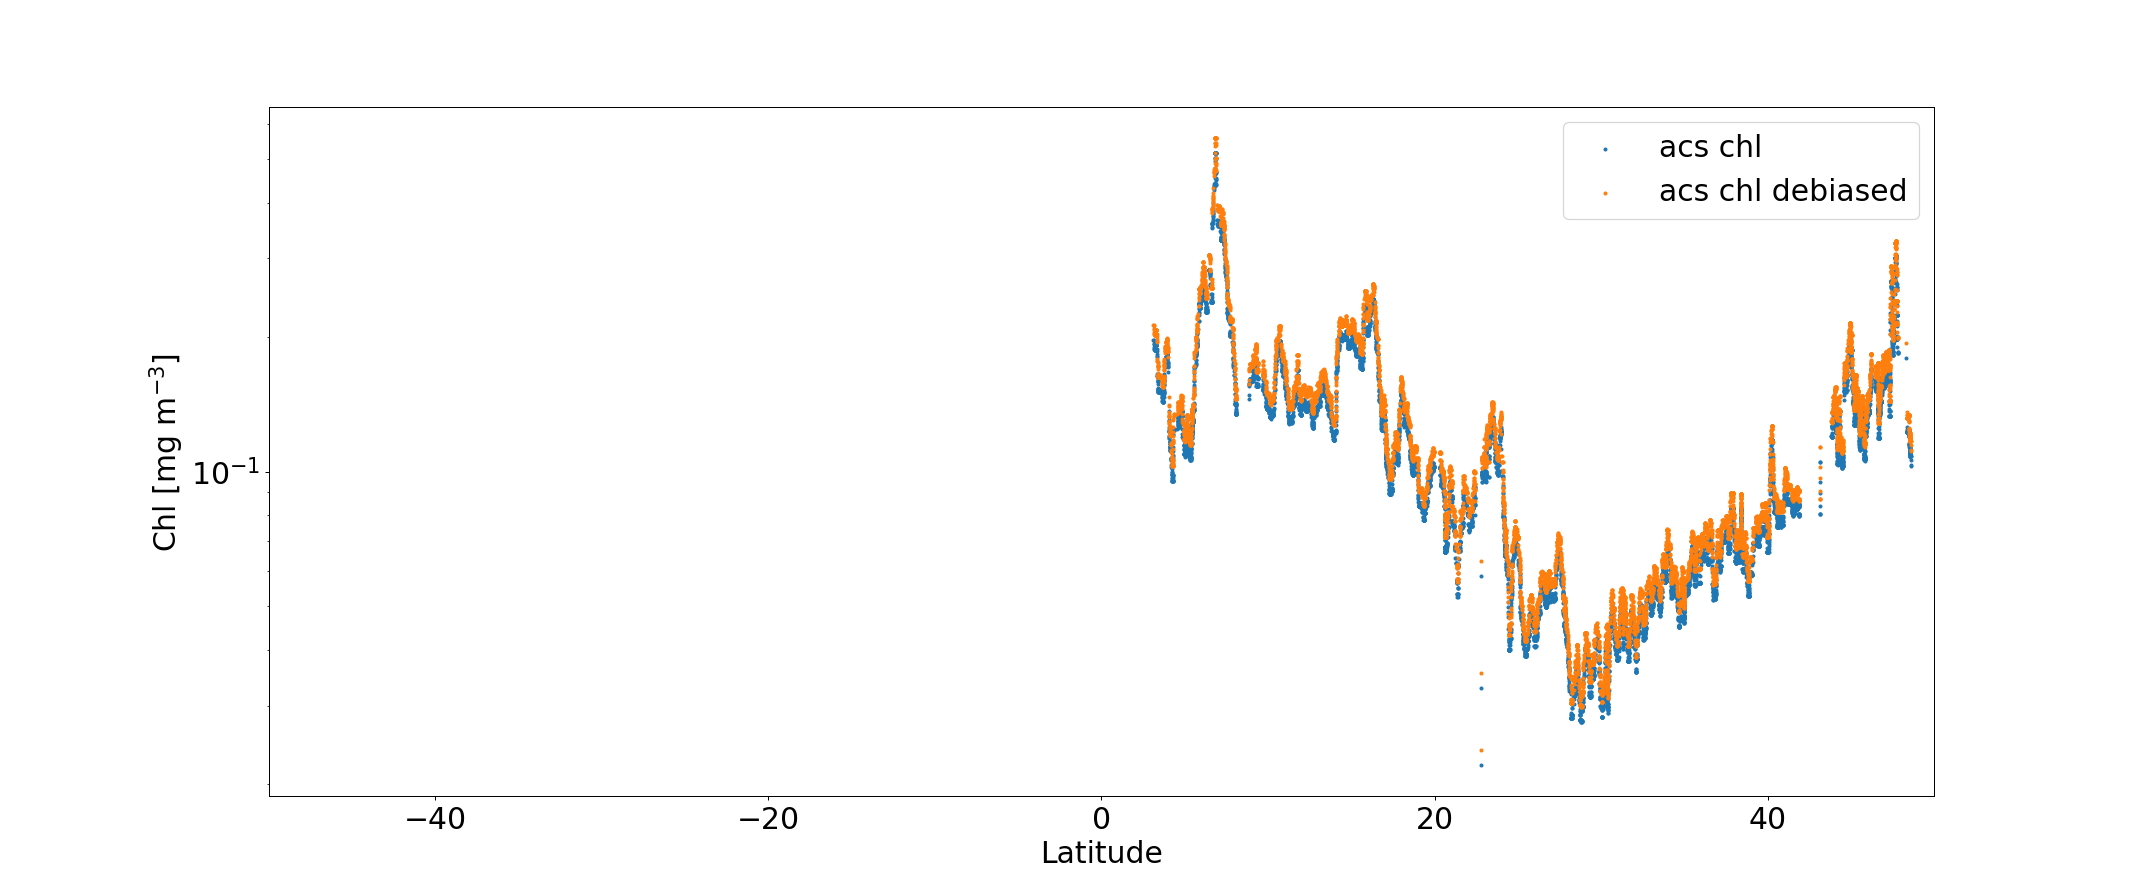

Text(0, 0.5, 'Chl [mg m$^{-3}$]')

In [73]:

# plot to show debiassing of chl
plt.figure(figsize=(24,10))
plt.rc('font', size=24)

plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acs_chl'], s=5,label='acs chl ')
plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acs_chl_debiased'], s=5,label='acs chl debiased')
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('Latitude')
plt.xlim(-50,50)
plt.ylabel('Chl [mg m$^{-3}$]')
    

<IPython.core.display.Javascript object>


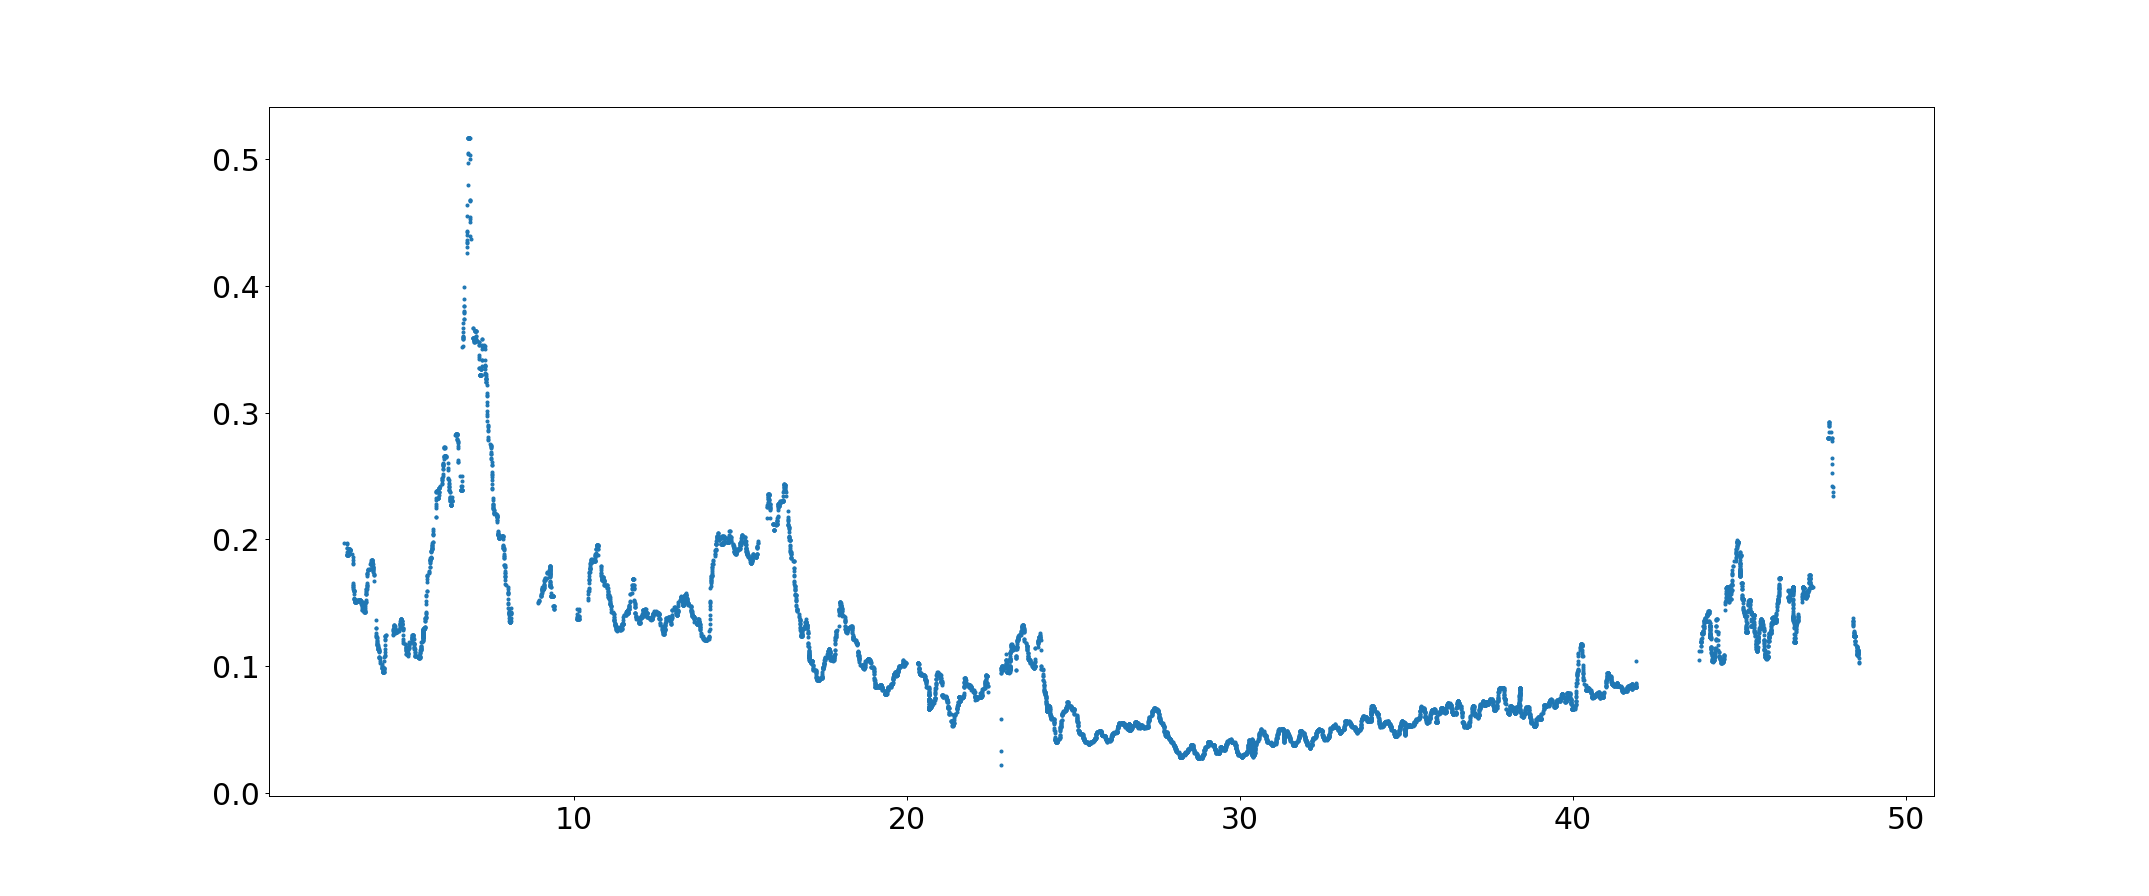

KeyError: 'ac9_chl'

In [73]:
# plot to show acs and ac9 chl separately
plt.figure(figsize=(24,10))
plt.rc('font', size=24)

plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acs_chl'], s=5,label='acs chl ')
plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['ac9_chl'], s=5,label='ac9 chl')
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('Latitude')
plt.xlim(-50,50)
plt.ylabel('Chl [mg m$^{-3}$]')

In [ ]:
plt.i
plt.plot(acs_filtered2['acs_chl'])

plt.plot(acs_filtered2['ac9_chl'])

In [ ]:
list(acs_filtered2.keys())